In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from IPython.display import display, clear_output
from scipy.optimize import fsolve, least_squares, minimize
from scipy.integrate import odeint, quad
from time import perf_counter
from scipy.interpolate import RectBivariateSpline
import pandas as pd
from numba import njit
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import importlib


Bad key text.latex.preview in file C:\Users\mcdon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\mcdon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\mcdon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
import ParamsPositionTarget as P #Write the name of your parameters file here. 
importlib.reload(P) #Reload to see any changes made to the parameter file.

##Parameters

#Saving files
folder = P.folder     #Folder to save to.
filename = P.filename #The name of the data files and plots that will be saved. 
save = P.save         #Save data files yes/no.

#Simulation parameters
t_end = P.t_end       #The end time (seconds).
length = P.length     #The length of the control region (meters). 
boundary_scale = P.boundary_scale #The simulation box size divided by the control region size. 
#The simulation box must be larger than the control region to make boundary effects small. Generally a value of 3 works well.
dt = P.dt             #The simulation timestep.

#Target function parameters
target_type = P.target_type #Specify if a circle or figure-eight target function will be used. Additional target functions may be added later.
v0 = P.v0             #The velocity scale used in the target function. This is the speed the particle travels at (meters/second).
v0_stakeholder = P.v0_stakeholder #this is supposed to be the speed the stakeholder moves at
rd = P.rd             #The length scale used in the target function. For a circular trajectory, this is the radius (meters).
n_stakeholders = P.n_stakeholders     #The number of stakeholders
initial_position = P.initial_position #The initial positions of particles (both passive and stakeholders).
#The first n_stakeholders entries are the initial positions of the stakeholders.
n_particles = len(initial_position)   #The number of particles (both passive and stakeholders).

#Physical parameters
mu = P.mu            #The diffusiophoretic mobility of the passive particles (m^2/(mole/m^3) s).                           
mu_e_stakeholder = P.mu_e_stakeholder #The electrophoretic mobility of the stakeholders (Coulomb/Newton *m/s or m^2/V s). 
epsilon = P.epsilon  #The dielectric constant of the fluid medium (C^2/Nm^2). 
D = P.D              #The diffusion coefficient of the solute. 
brownian_motion = P.brownian_motion  #Brownian motion on/off.
T = P.T              #Temperature in K
viscosity = P.viscosity  #The viscosity of the fluid medium.
radius = P.particle_radius  #The radius of the colloidal particle (meters). Currently, both passive particles and stakeholders are treated as the same size.
k_boltzmann = 1.38064852E-23 #Boltzmann's constant.
Dp = k_boltzmann*T/(viscosity*6*np.pi*radius) #The diffusion coefficient of the colloidal particles.

#Controller parameters
n_times = P.n_times   #The number of controller time steps to run for. The controller timestep is calculated as t_end/ntimes.
n_vision = P.n_vision #The prediction horizon for model predictive control.
W_1 = P.W_1           #The objective function weight on the residuals.
W_2 = P.W_2           #The objective function weight on the inputs.
W_3 = P.W_3           #The objective function weight on the penalty for overlapping with other particles. 
cutoff_percent = P.cutoff_percent #The percent of the kernel function to cut off. A larger percent will solve faster but be less accurate.
feedback_gain = P.feedback_gain   #The feedback gain used in the target function.
k_close = P.k_close   #The "safety" factor for how close two particles can be without getting penalized.

upper_bound_factor = P.upper_bound_factor       #multiple of uemax to set upper bound at. 1 is normal for a single particle.
strength = P.strength #
bounds = P.bounds


#some more setup stuff
t = np.linspace(0.0,t_end,n_times) #time of simulation in seconds 
delta_t = t[1] - t[0]
decision_times = t.copy() + 0.0000001    #array for decision times. 0.0000001 lets us avoid dividing by zero. 

    
umax = 2*np.pi*D*length*v0/np.abs(mu)         #characteristic scale for chemical reaction
uemax = 2*np.pi*epsilon*length*v0/np.abs(mu_e_stakeholder) #characteristic scale for electric charge
#ube = upper_bound_factor*uemax    #upper bound for electrode charge (or voltage? which one?) 

ube = upper_bound_factor*v0_stakeholder


simulation_length = boundary_scale*length    # simulation length
nxy     = 50*boundary_scale+1  # number of grid points in x and y directions
tFac    = 0.5                 # stability factor. Must be 0.5 or less
diffusive_timescale     = simulation_length**2/D            # diffusive timescale based on the whole domain.
deltaxy = simulation_length/(nxy-1)         # grid spacing in x and y directions
dtwant = tFac*deltaxy**2/D/4  # desired timestep size
if dt > dtwant:               #make sure to set this so that dt is a nice number smaller than dtwant
    print(dtwant)
    raise
dtratio = int(delta_t/dt)


###Functions

##target
if target_type == 'circle':
    xt = length/2         #center of the circle
    yt = length/2
    @njit #desired trajectory
    def target_trajectory(t):
        x = np.zeros(n_particles)
        y = np.zeros(n_particles)
        # x[0] = xt+rd*np.cos(v0*t/rd)
        # y[0] = yt+rd*np.sin(v0*t/rd)
        x[1] = xt+rd*np.cos(v0*t/rd) #fix this so it's not zero
        y[1] = yt+rd*np.sin(v0*t/rd)
        return np.vstack((x,y))

    @njit #velocity target (derivative of desired trajectory with a feedback correction)
    def target_velocity(xs,t,xyought):
        k = feedback_gain
        x = xs[0]
        y = xs[1]
        xought = xyought[0]
        yought = xyought[1]
        dx = np.zeros(n_particles)
        dy = np.zeros(n_particles)
        # dx[0] = -v0*np.sin(v0*t/rd)-k*(x[0]-xought[0])
        # dy[0] = v0*np.cos(v0*t/rd) -k*(y[0]-yought[0])
        dx[1] = -v0*np.sin(v0*t/rd) -k*(x[1]-xought[1])
        dy[1] =v0*np.cos(v0*t/rd) -k*(y[1]-yought[1])
        return np.vstack((dx,dy))
elif target_type == 'figure8':
    xt = length/2         #center of the figure-eight
    yt = length/2
    @njit #desired trajectory
    def target_trajectory(t):
        x = np.zeros(n_particles)
        y = np.zeros(n_particles)
        # x[0] = xt+rd*np.cos(v0*t/rd)
        # y[0] = yt+rd*np.sin(v0*t/rd)
        x[1] = xt+rd*np.sin(v0*t/rd)
        y[1] = yt+rd*np.sin(v0*t/rd)*np.cos(v0*t/rd)
        return np.vstack((x,y))

    @njit #velocity target (derivative of desired trajectory with a feedback correction)
    def target_velocity(xs,t,xyought):
        k = feedback_gain
        x = xs[0]
        y = xs[1]
        xought = xyought[0]
        yought = xyought[1]
        dx = np.zeros(n_particles)
        dy = np.zeros(n_particles)
        # dx[0] = -v0*np.sin(v0*t/rd)-k*(x[0]-xought[0])
        # dy[0] = v0*np.cos(v0*t/rd) -k*(y[0]-yought[0])
        dx[1] = v0*np.cos(v0*t/rd) -k*(x[1]-xought[1])
        dy[1] = v0*(-np.sin(v0*t/rd)**2+np.cos(v0*t/rd)**2) -k*(y[1]-yought[1])
        return np.vstack((dx,dy))
elif target_type == 'position':
    target_position = P.target_position
    def target_trajectory(t): #check if this is right dimensions
        return target_position
    
    def target_velocity(xs,t,chase_index): 
        k = feedback_gain
        x = xs[0]
        y = xs[1]    
        dx = np.zeros(n_particles)
        dy = np.zeros(n_particles)
        distance = np.sqrt((x[chase_index]-target_position[chase_index,0])**2 + (y[chase_index]-target_position[chase_index,1])**2)
        dx[chase_index] = v0*(target_position[chase_index,0]-x[chase_index])/distance
        dy[chase_index] = v0*(target_position[chase_index,1]-y[chase_index])/distance
        #the rest are zero
        return np.vstack((dx,dy))
else:
    raise Exception("target_type must be 'circle' or 'figure8'.")

little_r = P.little_r 
big_R = P.big_R    
G_path = P.G_path
H_path = P.H_path
G_obstacle = P.G_obstacle
H_obstacle = P.H_obstacle    
#This function gives a guidance vector field to move the stakeholder to the target while avoiding the obstacles.
#The paper it is based on moves the vehicle to the origin, so you must shift the coordinates so the target is the origin.
#@njit
def guidance_vector(position,target,obstacle): #the position of the stakeholder and the point it is trying to reach and the location of the obstacle
    x = position[0]/length-target[0]/length #shift coordinate frame so target is the origin, and scale by length
    y = position[1]/length-target[1]/length
    xc = np.zeros(len(obstacle[0]))
    yc = xc.copy()
    xbar = xc.copy()
    ybar = xc.copy()
    d = xc.copy()
    P = xc.copy()
    
    for i in range(len(obstacle[0])): #this might break when you get back to a single passive particle. Oh well. 
        xc[i] = obstacle[0,i]/length - target[0]/length 
        yc[i] = obstacle[1,i]/length - target[1]/length
        xbar[i] = x-xc[i]
        ybar[i] = y-yc[i]
        d[i] = np.sqrt(xbar[i]**2+ybar[i]**2)
        P[i] = 1-np.tanh(2*np.pi*d[i]/(big_R/length)-np.pi)
    delta = np.arctan2(y,x)
    V_circ = np.array([np.sin(delta),-np.cos(delta)])
    V_conv = -1/np.sqrt((np.cos(delta)*x+np.sin(delta)*y)**2)*np.array([x*np.cos(delta)**2+np.cos(delta)*np.sin(delta)*y,y*np.sin(delta)**2+np.cos(delta)*np.sin(delta)*x])
    V_path = G_path*V_conv + H_path*V_circ
    Vg = V_path
    for i in range(len(obstacle[0])):
        Vo_conv = -1/np.sqrt(xbar[i]**4+ybar[i]**4+2*xbar[i]**2*ybar[i]**2-2*little_r**2*xbar[i]**2-2*little_r**2*ybar[i]**2+little_r**2)*np.array([2*xbar[i]**3+2*xbar[i]*ybar[i]**2-2*little_r**2*xbar[i],2*ybar[i]**3+2*xbar[i]**2*ybar[i]-2*little_r**2*ybar[i]])
        Vo_circ = np.array([2*(y-yc[i]),2*(xc[i]-x)])
        V_obstacle = G_obstacle*Vo_conv+H_obstacle*Vo_circ
        Vg += P[i]*V_obstacle
    velocity = Vg
    return velocity/np.linalg.norm(velocity)*v0_stakeholder #try normalizing it, see if it works.    

# def guidance_vector(position,target,obstacle): #the position of the stakeholder and the point it is trying to reach and the location of the obstacle
#     x = position[0]/length-target[0]/length #shift coordinate frame so target is the origin, and scale by length
#     y = position[1]/length-target[1]/length
#     xc = obstacle[0]/length - target[0]/length 
#     yc = obstacle[0]/length - target[1]/length
#     xbar = x-xc
#     ybar = y-yc
#     d = np.sqrt(xbar**2+ybar**2)
#     P = 1-np.tanh(2*np.pi*d/(big_R/length)-np.pi)
#     delta = np.arctan2(y,x)
#     V_circ = np.array([np.sin(delta),-np.cos(delta)])
#     V_conv = -1/np.sqrt((np.cos(delta)*x+np.sin(delta)*y)**2)*np.array([x*np.cos(delta)**2+np.cos(delta)*np.sin(delta)*y,y*np.sin(delta)**2+np.cos(delta)*np.sin(delta)*x])
#     V_path = G_path*V_conv + H_path*V_circ
#     Vo_conv = -1/np.sqrt(xbar**4+ybar**4+2*xbar**2*ybar**2-2*little_r**2*xbar**2-2*little_r**2*ybar**2+little_r**2)*np.array([2*xbar**3+2*xbar*ybar**2-2*little_r**2*xbar,2*ybar**3+2*xbar**2*ybar-2*little_r**2*ybar])
#     Vo_circ = np.array([2*(y-yc),2*(xc-x)])
#     V_obstacle = G_obstacle*Vo_conv+H_obstacle*Vo_circ
#     Vg = V_path+P*V_obstacle
#     velocity = v0_stakeholder*Vg
#     return velocity/np.linalg.norm(velocity)*v0_stakeholder #try normalizing it, see if it works.  
    
##model

@njit #The chemical kernel for a single step function, or in other words, one half of delta h. 
def f(t,tn,r,u_i,mu, D): 
    if t>tn:
        rsquared = r**2
        return -mu*u_i*np.exp(-rsquared/(4*D*(t-tn)))/(2*D*np.pi*rsquared) #note that this is missing the (x-x0), added in the chemical_velocity function.
    else:
        return 0

# Find the cutoff time.   
def find_cutoff(tdiff, delta_t):
    def h0_derivative(t): #The derivative of delta h.
        if t <= delta_t:
            return 1E8 #Set to a big number so the solver avoids it, this is how I implement the Heaviside function.
        else:
            return np.exp(-tdiff/t)/t**2-np.exp(-tdiff/(t-delta_t))/(t-delta_t)**2
    maximum = fsolve(h0_derivative,0.5*tdiff + 3/4*delta_t) 
    def h0(t):
        return np.exp(-tdiff/t)-np.exp(-tdiff/(t-delta_t))
    def function_to_solve(t):
        return h0(t) - cutoff_percent*h0(maximum)
    answer = fsolve(function_to_solve,8*tdiff) #If it doesn't work, try a new guess value here
    return answer[0]
tdiff = length**2/4/D
tcutoff = find_cutoff(4*tdiff,delta_t)
if tcutoff < 0:
    raise     #If this raises an exception, try a new guess value above
ncutoffsteps = int(tcutoff/delta_t) #number of timesteps before cutoff. Note that this rounds down. Maybe you don't want that.



@njit #finds chemical contribution to vx and vy
def chemical_velocity(xy,t,stakepos,u,decision_times, mu, D,stakehistory): 
    x = xy[0]
    y = xy[1]
    vx = 0
    vy = 0
    for i in range(len(stakehistory)+1): 
        for j in range(n_stakeholders):
            if i == len(stakehistory):#Don't actually need this because decision_times>t here. #It actually does get used, what did I mean by that?
                rad = np.sqrt((stakepos[0,j]-x)**2 + (stakepos[1,j]-y)**2)
                if rad < radius:
                    continue
                vx += f(t,decision_times[i],rad,u[j,i],mu,D)*(x-stakepos[0,j])
                vx -= f(t,decision_times[i] + delta_t,rad,u[j,i],mu,D)*(x-stakepos[0,j])
                vy += f(t,decision_times[i],rad,u[j,i],mu,D)*(y-stakepos[1,j]) 
                vy -= f(t,decision_times[i] + delta_t,rad,u[j,i],mu,D)*(y-stakepos[1,j])
            else:  
                rad = np.sqrt((stakehistory[i,0,j]-x)**2 +(stakehistory[i,1,j]-y)**2)
                if rad < radius:
                    continue
                vx += f(t,decision_times[i],rad,u[j,i],mu,D)*(x-stakehistory[i,0,j])
                vx -= f(t,decision_times[i] + delta_t,rad,u[j,i],mu,D)*(x-stakehistory[i,0,j])
                vy += f(t,decision_times[i],rad,u[j,i],mu,D)*(y-stakehistory[i,1,j])
                vy -= f(t,decision_times[i] + delta_t,rad,u[j,i],mu,D)*(y-stakehistory[i,1,j])
    return np.array([vx,vy])

@njit #model for particle motion given a set of reaction rates and voltages
def model(uchem,xstake,decision_times, measurement,start, stop, mu, D, stakehistory): 
    xy  = np.zeros((stop-start + 1,2,n_particles))
    dxy = np.zeros((stop-start + 1,2,n_particles)) 
    xy[0] = measurement
    #initial time point
    for j in range(n_particles):
        if j < n_stakeholders:
            #dxy[0,:,j] = dstake[0]
            #xy[1,:,j] = xstake[0]
            cm #get rid of this
        else:
            dxy[0,:,j]  = chemical_velocity(xy[0,:,j],t[start],xy[0,:,:n_stakeholders],uchem,decision_times,mu, D,stakehistory) #maybe speed it up by only passing a slice of u
    #loop over time 
    stakehistoryexpanded = stakehistory
    for i in range(1,stop-start+1): 
        xy[i,:,n_stakeholders:] = xy[i-1,:,n_stakeholders:] + dxy[i-1,:,n_stakeholders:]*delta_t #Explicit Euler                 
        stakehistoryexpanded = np.append(stakehistoryexpanded,np.expand_dims(xy[i-1,:,:n_stakeholders],0),0)
        for j in range(n_particles):
            if j < n_stakeholders:
                #dxy[i,:,j] = dstake[i]
                xy[i,:,j] = xstake[i-1] #not built for j > 1
            else:
                dxy[i,:,j]  = chemical_velocity(xy[i,:,j],t[i+start],xy[i,:,:n_stakeholders],uchem,decision_times,mu, D,stakehistoryexpanded)    
    return (dxy,xy)

## cost function

#@njit #cost function #numba breaks this function in a way I do not understand. Probably from taking i externally! Fix that! 
def objective(u,decision_times, previousu,xypos,start, stakehistory,chase_index): 
    tooclose = np.zeros(n_vision+1)
    #dstake = np.reshape(u,(n_vision+1,2))
    xstake = np.reshape(u,(n_vision+1,2))
    uchem = np.ones((n_stakeholders,n_vision+1))*umax*strength #in the future this might be calculated, but for now it's static.
    temp = np.hstack((previousu[0,:],uchem[0,:]))
    uchemcombined = np.expand_dims(temp,0)
    for pro in range(1,n_stakeholders):
        temp = np.hstack((previousu[pro,:],uchem[pro,:]))
        temp1 = np.expand_dims(temp,0)
        uchemcombined = np.vstack((uchemcombined,temp1)) 
    vxy,xys = model(uchemcombined,xstake,decision_times,xypos,start, start+n_vision, mu, D, stakehistory)  
    
    target = np.zeros((n_vision+1,2,n_particles))
    for k in range(n_vision+1): #initial point plus n_vision into future
        target[k] = target_velocity(xys[k],t[i+k],chase_index) #It's taking i externally here, that's a little weird.
        for j in range(n_stakeholders,n_particles): #skip over the stakeholders
            rij = np.sqrt((xys[k,0,0] - xys[k,0,j])**2 + (xys[k,1,0] - xys[k,1,j])**2)
            tooclose[k] += max(0,(k_close*2*radius-rij)) #the += might mess things up?
    #residual = vxy[:,:,chase_index] - target[:,:,chase_index] #should really pass chase_index as parameter of function
    residual = xys[:,:,chase_index]-target_position[chase_index,:]  #do first and second actually matter?
    # if chase_index == 0:
    #     residual = xys[:,:,chase_index]*v0/radius/100- target[:,:,chase_index] #These arrays might not be the same length, could be a problem.
        #it is strange to switch from v objective to x objective like this, is there a better way?
    return np.concatenate((W_1*residual.flatten()/length,W_3*tooclose.flatten()/radius)) 
    

##Process  

#some preliminary stuff
grid = np.zeros((nxy,nxy))     # solution array
#Because of the way we index variables on the meshgrid, we have to transpose grid when we want to plot it.
#This is because X[0] doesn't give the first x value, but X[:,0] does. Instead of reversing the indices on everything, it is easier to just transpose the final resuult.
Sources = np.zeros((nxy,nxy))  # source term array. 


interval = (boundary_scale-1)/2
x = np.linspace(-interval*length,(1+interval)*length,nxy)
y = np.linspace(-interval*length,(1+interval)*length,nxy)
X,Y = np.meshgrid(x,y) 

nTauRun = t_end/diffusive_timescale              # number of intrinsic timescale to run for
t_end = nTauRun*diffusive_timescale              # Change the end time so it is a multiple of the diffusive timescale.
#will this cause problems with the controller times not lining up? Might have to change this.
nt   = int(np.ceil(t_end/dt)) +1 # number of timesteps
tlarge = np.linspace(0,t_end,nt)




@njit #this does one iteration of the Gauss-Seidel algorithm 
def finite_difference(grid,Sources):
    for iindex in range(1,nxy-1):
        for jindex in range(1,nxy-1):
            grid[iindex,jindex] += (
                D*dt/deltaxy**2*(grid[iindex-1,jindex] - 2*grid[iindex,jindex] + grid[iindex+1,jindex]) + 
                D*dt/deltaxy**2*(grid[iindex,jindex-1] - 2*grid[iindex,jindex] + grid[iindex,jindex+1]) + 
                dt*Sources[iindex,jindex]/deltaxy**2 )#Divide the last term by deltaxy^2 to get concentration.
              #Zero boundary conditions
    return

xindex = np.zeros(n_stakeholders, dtype = int)
yindex = np.zeros(n_stakeholders, dtype = int)

#this function runs the physics and gives the resulting positions
def process(uchem,stake_target,grid,time, initialpos,chase_index): 
    xy = np.zeros((len(time),2,n_particles))
    xy[0] = initialpos
    vxy = np.zeros((len(time),2,n_particles))
    for k in range(len(time)-1): 
        for n in range(n_stakeholders):
            #Set previous stakeholder source term back to zero.
            Sources[xindex[n],yindex[n]] = 0  
            #Find the new location for the stakeholder source term.
            xindex[n] = np.argmin((X[0,:]-xy[k,0,n])**2)
            yindex[n] = np.argmin((Y[:,0]-xy[k,1,n])**2)
            Sources[xindex[n],yindex[n]] = uchem[n] 
        finite_difference(grid,Sources)
        interp = RectBivariateSpline(x,y,grid) #default for RectBivariateSpline is cubic interpolation
        for m in range(n_particles):
            if m < n_stakeholders: #chase_index might mess it up when chase_index == 0
                #v_desired = guidance_vector(xy[k,:,0],stake_target, xy[k,:,chase_index]) #this is for chased particle, then will need to do for others. 
                v_desired = guidance_vector(xy[k,:,0],stake_target, xy[k,:,n_stakeholders:])
                vxy[k,0,m] = np.clip(v_desired[0],-ube,ube) #don't really need to clip this now that i've normalized guidance_vector.
                vxy[k,1,m] = np.clip(v_desired[1],-ube,ube)
                #print("The",v_desired,vxy[k,:,m])
                # xy[k+1,0,m] = xy[k,0,m]+vxy[k,0,m]*dt#xstake[0]
                # xy[k+1,1,m] = xy[k,1,m]+vxy[k,1,m]*dt#xstake[1]
                
            else:
                vxy[k,0,m] = mu*(interp(xy[k-1,0,m]+deltaxy,xy[k-1,1,m]) - interp(xy[k-1,0,m]-deltaxy,xy[k-1,1,m]))/(2*deltaxy) + brownian_motion*np.random.normal(0,1)*np.sqrt(2*Dp)/np.sqrt(dt)
                vxy[k,1,m] = mu*(interp(xy[k-1,0,m],xy[k-1,1,m]+deltaxy) - interp(xy[k-1,0,m],xy[k-1,1,m]-deltaxy))/(2*deltaxy) + brownian_motion*np.random.normal(0,1)*np.sqrt(2*Dp)/np.sqrt(dt)
            #xy[k+1,:,n_stakeholders:] = xy[k,:,n_stakeholders:] + vxy[k,:,n_stakeholders:]*dt 
            xy[k+1,:,:] = xy[k,:,:] + vxy[k,:,:]*dt
            
        # #hard sphere interactions.
            xcheck = xy[k,0,:] #notice this is not making a copy, it is just attaching a name to this section of the data.
            ycheck = xy[k,1,:]
            for ii in range(n_stakeholders,n_particles):
                for jj in range(n_particles):
                    if ii != jj:
                        dij = np.sqrt((xcheck[ii]-xcheck[jj])**2+(ycheck[ii]-ycheck[jj])**2)           
                        if dij < 2*radius:
                            xcheck[ii] = xcheck[ii] - 1*(dij-2*radius)*(xcheck[ii]-xcheck[jj])/dij
                            ycheck[ii] = ycheck[ii] - 1*(dij-2*radius)*(ycheck[ii]-ycheck[jj])/dij
    return (xy[-1])


##Plotting

cm = 1E6 #this is to show the plot in micrometers (used to be centimeters)
Clow = 0
Chigh = 0.3 #0.6
Elow = 0
Ehigh = 0.03
margin = length/10
lower = 0-margin
higher = length+margin
ntail = 30
marksize = 0.75*0.775*2*radius*234/(higher-lower)#72 points per inch times 3.25 inches across=234. 0.775 is to account for axis label 
#the 0.75 is a fudge factor to make it look right. I can't figure out why, but without it the plot is wrong. 

#plotting function
plt.rc("font",size = 10)
# targett = np.zeros((len(t),2))
# for i in range(len(t)):
#     targett[i] = target_trajectory(t[i])[n_stakeholders:,1] #this might be wrong
def plotter(k,xanswer,yanswer,uresult):
    plt.figure(figsize=(3.25, 3.25), dpi= 200, facecolor='w', edgecolor='k')
    plt.xlabel("Position ($\mu$m)", fontsize = 12) 
    #plt.plot(targett[:380,0]*cm,targett[:380,1]*cm, "r--", lw = 0.75) #why 380? this should be a parameter.
    if target_type == 'position':
        plt.plot(target_position[:,0]*cm,target_position[:,1]*cm,'x',color = 'r') #double check this
    plt.plot(uresult[0]*cm,uresult[1]*cm,'x',color = 'g')
    #plot passive particles    
    plt.plot(xanswer[k,n_stakeholders:]*cm,yanswer[k,n_stakeholders:]*cm, "o", color = "r", markersize = marksize)
    if k< ntail:
        plt.plot(xanswer[:k+1,n_stakeholders:]*cm,yanswer[:k+1,n_stakeholders:]*cm,color = "r", linewidth = 1.5)
    else:
        plt.plot(xanswer[k-ntail:k+1,n_stakeholders:]*cm,yanswer[k-ntail:k+1,n_stakeholders:]*cm,color = "r", linewidth = 1.5)
    #plt.plot(x0[:,0]*cm, x0[:,1]*cm, "s", markersize = 10,color = "royalblue")
    #plot stakeholders
    plt.plot(xanswer[k,:n_stakeholders]*cm,yanswer[k,:n_stakeholders]*cm, "o", color = "tab:orange", markersize = marksize)
    if k< ntail:
        plt.plot(xanswer[:k+1,:n_stakeholders]*cm,yanswer[:k+1,:n_stakeholders]*cm,color = "tab:orange", linewidth = 1.5)
    else:
        plt.plot(xanswer[k-ntail:k+1,:n_stakeholders]*cm,yanswer[k-ntail:k+1,:n_stakeholders]*cm,color = "tab:orange", linewidth = 1.5)
    axes = plt.gca()
    divider = make_axes_locatable(axes)
    # if mode == "chemical":
    plt.contourf(X*cm,Y*cm,grid.T/1000,levels=np.linspace(Clow,Chigh,26), extend = "max") #recall that grid must be transposed to give the correct plot.
    cax = divider.append_axes("left", size = "5%", pad = 0.05)
    colorbar = plt.colorbar(cax = cax, shrink = 0.81, pad = 0.03)
    colorbar.set_label("Concentration ($\dfrac{\mathrm{mol}}{\mathrm{L}}$)", fontsize = 12)   
    cax.yaxis.tick_left()
    cax.yaxis.set_label_position('left')
    axes.set_aspect('equal', adjustable='box')
    axes.set_xlim([lower*cm,higher*cm])
    axes.set_ylim([lower*cm,higher*cm])
    axes.yaxis.tick_right()
    clear_output(wait=True)
    display(plt.gcf())
    kfilled = str(k).zfill(5)
    plt.savefig(f"{folder}/{filename}Plot{kfilled}.png",bbox_inches="tight") 
    plt.close()
    return


##Save data

#use this to write the data to a file (not yet implemented)
def save_data(k):
    dataframe1 = pd.DataFrame(t,columns = ("Time",))
    for i in range(len(ustoreelec[0])):
        dataframe1["U"+str(i)] = pd.Series(ustoreelec[:,i])  
    for j in range(n_particles):
        dataframe1["X"+str(j)] = pd.Series(xy[:,0,j])
        dataframe1["Y"+str(j)] = pd.Series(xy[:,1,j])
    dataframe2 = pd.DataFrame({"length": length, "rd": rd, "v0":v0, "W_1": W_1, "mu":mu,"D":D, "R": radius}, index = [0])
    dataframeCombined = pd.concat([dataframe1,dataframe2], axis = 1)
    kfilled = str(k).zfill(5)
    dataframeCombined.to_csv(f"{folder}/{filename}Data{kfilled}.csv")
    dataframeGrid = pd.DataFrame(grid)
    dataframeGrid.to_csv(f"{folder}/{filename}Grid{kfilled}.csv")
    return
print("Done")

Done


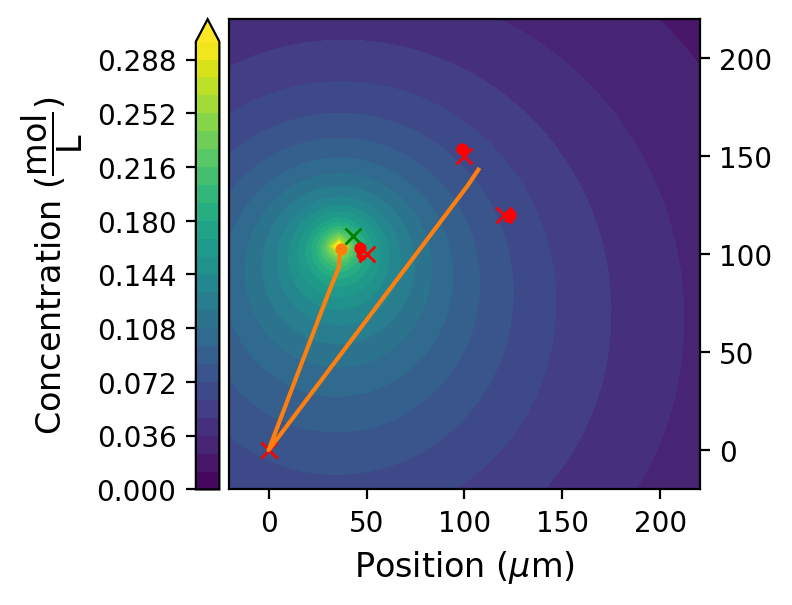

597 41
[-0.37203218  0.33319258 -0.35699345  0.35509287 -0.32753488  0.3855365
 -0.27564534  0.31175261]
[0. 0. 0. 0.]
[4.31590259e-05 1.09283320e-04]


In [3]:
##run simulation and controller
xy = np.zeros((n_times,2,n_particles))
xy[0] = initial_position.T
vxy = np.zeros((n_times,2,n_particles))
##vxy[0] is zero
uguess = np.zeros(2*(n_vision+1))#+length/2 #oh no, the guess value matters!

ustore = np.zeros((n_times,n_stakeholders))
grid = np.zeros((nxy,nxy))     # solution array. This is a duplicate
modelpos = xy.copy()
timer = np.zeros(len(t))
switch_targets = True

for i in range(n_times-n_vision): #could turn this into a while loop
    #switching rule
    distance = np.sqrt((xy[i,0,:]-target_position[:,0])**2 + (xy[i,1,:]-target_position[:,1])**2)
    if (distance[n_stakeholders:] > radius).any():
        if switch_targets:
            chase_index = np.argmax(distance[n_stakeholders:])+n_stakeholders
            switch_targets = False
            #heuristic for choosing guess value
            right = np.sign(xy[i,0,chase_index]-target_position[chase_index,0]) #particle is to the right of target if this is positive
            above = np.sign(xy[i,1,chase_index]-target_position[chase_index,1]) #particle is above target if this is positive
            # uguess[::2] = length/2+right*length/2
            # uguess[1::2]=length/2+above*length/2
            uguess[::2] = xy[i,0,chase_index]+right*4*radius
            uguess[1::2]=xy[i,1,chase_index]+above*4*radius
            #double check that this is how the array works
        elif distance[chase_index] < radius:
            switch_targets = True      
    else:
        chase_index = 0
    stakehistory =  xy[:,:,:n_stakeholders] #the past positions of the stakeholders. Goes into model. Needs a cutoff. 
    time0 = perf_counter()
    if i == 0: #this is sort of a janky fix to make array sizes work 
        result = least_squares(objective,uguess, bounds = bounds,args = (decision_times[:i+n_vision+1],np.zeros((n_stakeholders,0)), xy[i],i,stakehistory[:i],chase_index),verbose = 1) 
    elif i < ncutoffsteps: 
        result = least_squares(objective,uguess, bounds = bounds,args = (decision_times[:i+n_vision+1],ustore[:i].T, xy[i],i,stakehistory[:i],chase_index),verbose = 1)
    else:
        result = least_squares(objective,uguess, bounds = bounds, args = (decision_times[i-ncutoffsteps:i+n_vision+1],ustore[i-ncutoffsteps:i].T, xy[i],i,stakehistory[i-ncutoffsteps:i],chase_index),verbose = 1)
    time1 = perf_counter()
    timer[i] = time1-time0
    uresult = result.x #this gives the input divided by uemax. 
    #uguess[:len(uresult)] = uresult
    uresultchem = np.ones((n_stakeholders,n_vision))*umax*strength #this is now in two places. Fix it.
    xy[i+1] = process(uresultchem[:,0],uresult[:2],grid,tlarge[i*dtratio:(i+1)*dtratio],xy[i],chase_index)
    ustore[i] =  uresultchem[:,0] #maybe fixed now
    
    plotter(i+1,xy[:,0],xy[:,1],uresult[:2])
    if save:
        save_data(i)
    print(i, result.nfev)
    print(result.fun[:-(n_vision+1)])
    print(result.fun[-(n_vision+1):])
    print(uresult[:2])


In [4]:
print(chase_index)
print(right)
print(above)
print(uguess)

3
-1.0
1.0
[3.37295354e-05 1.13831830e-04 3.37295354e-05 1.13831830e-04
 3.37295354e-05 1.13831830e-04 3.37295354e-05 1.13831830e-04]


[-1.99007438e-06 -1.99007438e-05]
[6.73954960e-07 6.73132508e-06]


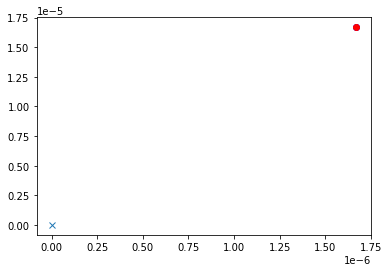

In [9]:
stakepos = xy[i,:,0]
obstacle = xy[i,:,chase_index]
target = uresult[:2]
print(guidance_vector(stakepos,target,obstacle))
print(xy[i,:,0]+guidance_vector(stakepos,target,obstacle)*delta_t)
#print(stakepos,target,obstacle)
plt.plot(stakepos[0],stakepos[1],'o',color='b')
plt.plot(obstacle[0],obstacle[1],'o',color='r')
plt.plot(target[0],target[1],'x')

Text(0, 0.5, 'Time to solve (s)')

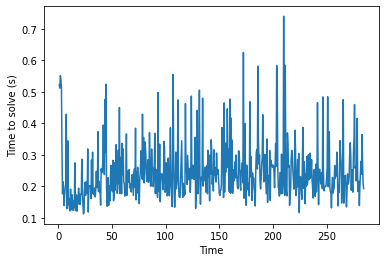

In [134]:
plt.plot(t[2:i],timer[2:i])
plt.xlabel("Time")
plt.ylabel("Time to solve (s)")
#plt.savefig("TimetosolveNobrownZero.png",bbox_inches='tight')

[[3.35234088e-05 4.69325276e-05]
 [3.35318658e-05 4.68591249e-05]
 [3.35392513e-05 4.67960350e-05]
 [3.35433551e-05 4.67527826e-05]]
[0.0001  0.00015]
[[ -6.64765912 -10.30674724]
 [ -6.64681342 -10.31408751]
 [ -6.64607487 -10.3203965 ]
 [ -6.64566449 -10.32472174]]
602.4265707572597


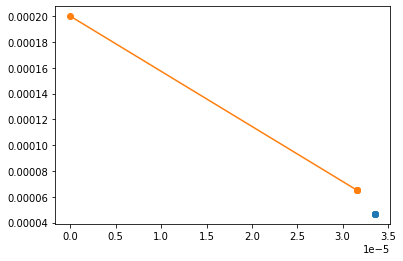

In [176]:
previousu = ustore[:i].T
uchem = np.ones((n_stakeholders,n_vision+1))*umax*strength #in the future this might be calculated, but for now it's static.
temp = np.hstack((previousu[0,:],uchem[0,:]))
uchemcombined = np.expand_dims(temp,0)

u = uresult
# u = uresult*0
# u[::2] = 0.00009
# u[1::2] = 0.00004
xstake = np.reshape(u,(n_vision+1,2))
decision_tim = decision_times[:i+n_vision+1]
xypos = xy[i]
start = i
stakehist = stakehistory[:i]

# (u,decision_times, previousu,xypos,start, stakehistory,chase_index)
# args = (decision_times[:i+n_vision+1],ustore[:i].T, xy[i],i,stakehistory[:i],chase_index)
vxy,xys = model(uchemcombined,xstake,decision_tim,xypos,start, start+n_vision, mu, D, stakehist)
print(xys[:,:,chase_index])
print(target_position[chase_index,:])

residual = xys[:,:,chase_index]-target_position[chase_index,:]
print(W_1*residual/length)
print(np.sum((W_1*residual/length)**2))
#why does this make it higher?
#plt.plot(residual[:,0],residual[:,1],'-o')
plt.plot(xys[:,0,chase_index],xys[:,1,chase_index],'-o')
plt.plot(u[::2],u[1::2],'-o')

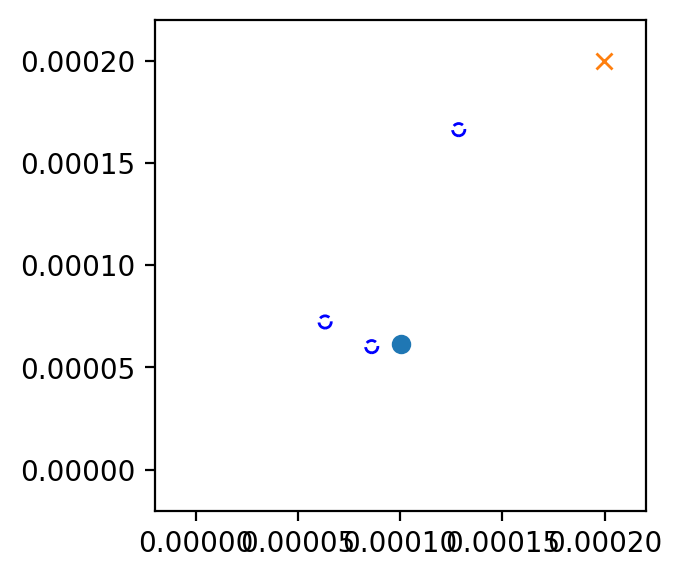

In [32]:
import time
def guidance_vector(position,target,obstacle): #the position of the stakeholder and the point it is trying to reach and the location of the obstacle
    x = position[0]/length-target[0]/length #shift coordinate frame so target is the origin, and scale by length
    y = position[1]/length-target[1]/length
    xc = np.zeros(len(obstacle[0]))
    yc = xc.copy()
    xbar = xc.copy()
    ybar = xc.copy()
    d = xc.copy()
    P = xc.copy()
    
    for i in range(len(obstacle[0])): #this might break when you get back to a single passive particle. Oh well. 
        xc[i] = obstacle[0,i]/length - target[0]/length 
        yc[i] = obstacle[1,i]/length - target[1]/length
        xbar[i] = x-xc[i]
        ybar[i] = y-yc[i]
        d[i] = np.sqrt(xbar[i]**2+ybar[i]**2)
        P[i] = 1-np.tanh(2*np.pi*d[i]/(big_R/length)-np.pi)
    delta = np.arctan2(y,x)
    V_circ = np.array([np.sin(delta),-np.cos(delta)])
    V_conv = -1/np.sqrt((np.cos(delta)*x+np.sin(delta)*y)**2)*np.array([x*np.cos(delta)**2+np.cos(delta)*np.sin(delta)*y,y*np.sin(delta)**2+np.cos(delta)*np.sin(delta)*x])
    V_path = G_path*V_conv + H_path*V_circ
    Vg = 0
    for i in range(len(obstacle[0])):
        Vo_conv = -1/np.sqrt(xbar[i]**4+ybar[i]**4+2*xbar[i]**2*ybar[i]**2-2*little_r**2*xbar[i]**2-2*little_r**2*ybar[i]**2+little_r**2)*np.array([2*xbar[i]**3+2*xbar[i]*ybar[i]**2-2*little_r**2*xbar[i],2*ybar[i]**3+2*xbar[i]**2*ybar[i]-2*little_r**2*ybar[i]])
        print(np.sqrt(xbar[i]**4+ybar[i]**4+2*xbar[i]**2*ybar[i]**2-2*little_r**2*xbar[i]**2-2*little_r**2*ybar[i]**2+little_r**2)*np.array([2*xbar[i]**3+2*xbar[i]*ybar[i]**2-2*little_r**2*xbar[i],2*ybar[i]**3+2*xbar[i]**2*ybar[i]-2*little_r**2*ybar[i]]))
        Vo_circ = np.array([2*(y-yc[i]),2*(xc[i]-x)])
        V_obstacle = G_obstacle*Vo_conv+H_obstacle*Vo_circ
        Vg += V_path+P[i]*V_obstacle
    velocity = Vg
    return velocity/np.linalg.norm(velocity)*v0_stakeholder #try normalizing it, see if it works. 

def plotter(i):
    plt.figure(figsize=(3.25, 3.25), dpi= 200, facecolor='w', edgecolor='k')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(x[i],y[i],'o')
    #plt.plot(obstacle[0]+target[0],obstacle[1]+target[1],'x')
    plt.plot(target[0],target[1],'x')
    #plt.gca().add_patch(patches.Circle((xc+target[0], yc+target[1]), R, linestyle = '--', color='r',fill=False, lw = 1))
    for j in range(n_particles-n_stakeholders):
        plt.gca().add_patch(patches.Circle((obstacle[0,j], obstacle[1,j]), radius, linestyle = '--', color='b',fill=False, lw = 1))
    plt.gca().set_xlim([lower,higher])
    plt.gca().set_ylim([lower,higher])
    clear_output(wait=True)
    display(plt.gcf())
    kfilled = str(i).zfill(5)
    #plt.savefig(f"{folder}/{filename}Plot{kfilled}.png",bbox_inches="tight") 
    plt.close()
    
tee = tlarge[i*dtratio:(i+1)*dtratio]
t = np.linspace(tee[0],tee[-1],30)
dt = t[1]-t[0]
#v_desired = guidance_vector(xy[k,:,0],stake_target, xy[k,:,:])
obstacle = xy[i,:,n_stakeholders:]
target = uresult[:2]
x = np.zeros(len(t))
y = np.zeros(len(t))
x[0] = xy[i,0,0]
y[0] = xy[i,1,0]
vx = np.zeros(len(t))
vy = np.zeros(len(t))
vx[0],vy[0] = guidance_vector(np.array([x[0],y[0]]),target,obstacle)
for i in range(1,len(t)):
    x[i] = x[i-1]+vx[i-1]*dt
    y[i] = y[i-1]+vy[i-1]*dt
    vx[i],vy[i] = guidance_vector(np.array([x[i],y[i]]),target,obstacle)
    plotter(i)
    time.sleep(0.2)

In [31]:
t = np.arange(tee[0],tee[-1],30)
print(t)
print(tee[0])
print(tee[-1])

[29.]
29.0
29.499200000000002
